# Neutron output vs beam power

Measurement from 2020-02-03. File in: /Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower

In [65]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

In [66]:
DAY = "2020-02-03"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/'

## Load from PSI DB

In [ ]:
# reference detectors
# dose
# HV

# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)

# get microwave power
query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_power_full = con.get_from_database(query=query)

# get microwave frequency
query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_frequency_full = con.get_from_database(query=query)


### Some plots

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
plt.show()


In [ ]:
data_dose.to_csv(f'{PATH}/{DAY}_dose.csv')
data_hv.to_csv(f'{PATH}/{DAY}_hv.csv')
data_pressure.to_csv(f'{PATH}/{DAY}_pressure.csv')
data_microwave_power_full.to_csv(f'{PATH}/{DAY}_microwave_power.csv')
data_microwave_frequency_full.to_csv(f'{PATH}/{DAY}_microwave_.csv')

## Load from csv

In [67]:
data_dose = pd.read_csv(f'{PATH}/{DAY}_dose.csv', index_col=0)
data_hv = pd.read_csv(f'{PATH}/{DAY}_hv.csv', index_col=0)
data_pressure = pd.read_csv(f'{PATH}/{DAY}_pressure.csv', index_col=0)
data_microwave_power_full = pd.read_csv(f'{PATH}/{DAY}_microwave_power.csv', index_col=0)
data_microwave_frequency_full = pd.read_csv(f'{PATH}/{DAY}_microwave_frequency.csv', index_col=0)

for df in [data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full]:
    df.index = pd.to_datetime(df.index)

    
time_start = f"{DAY} 07:30:00"
time_end = f"{DAY} 11:00:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]
data_microwave_power = data_microwave_power_full.loc[time_start:time_end, :]
data_microwave_frequency = data_microwave_frequency_full.loc[time_start:time_end, :]

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
plt.show()


## Leakage current versus high voltage

In [68]:
t0 = f"{DAY} 08:18:00"
t1 = f"{DAY} 08:25:00"


data_dose_lk = data_dose.loc[t0:t1, :]
data_hv_lk = data_hv.loc[t0:t1, :]


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose_lk.index, y='dose_corrected', data=data_dose_lk, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_lk.index, y='HV_voltage', data=data_hv_lk, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_lk.index, y='HV_current', data=data_hv_lk, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

### Put in one dataframe


In [69]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out


In [70]:
d_hv = resample_30_seconds(data_hv_lk, ['HV_current', 'HV_voltage'], t0, t1) 
d_dose = resample_30_seconds(data_dose_lk, ['dose_corrected'], t0, t1) 

data = pd.merge(d_hv, d_dose, left_index=True, right_index=True, how='outer') # dose is actually not needed
data.head()

,HV_current,HV_voltage,dose_corrected
time,,,
2020-02-03 08:18:00,0.58516,146.64,5.192839
2020-02-03 08:18:10,0.62476,150.00,2.796144
2020-02-03 08:18:20,0.60980,148.11,5.192839
2020-02-03 08:18:30,0.57680,145.20,7.589534
2020-02-03 08:18:40,0.57636,145.20,5.192839


In [71]:
sns.reset_orig()

In [72]:

import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [73]:
OUTPUT_FOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Leakage_current_vs_high_voltage/'
FIGNAME = 'Leakage_current_vs_high_voltage'

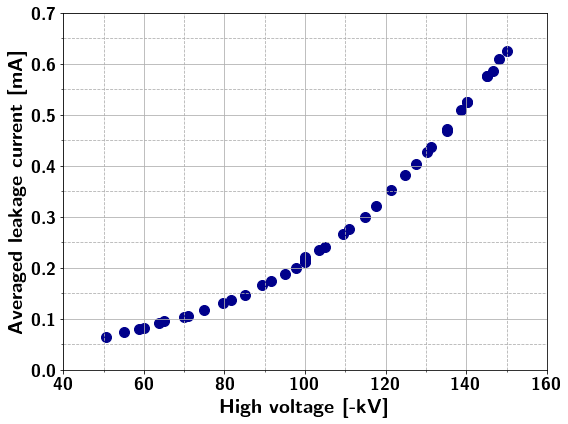

In [74]:
fig = plt.figure(figsize=(8,6))
fs = 20

plt.scatter(data['HV_voltage'].values, data['HV_current'].values, color='darkblue', s=100)

ax = plt.gca()

_ = plt.ylabel(r'\textbf{Averaged leakage current [mA]}',fontsize=fs)
_ = plt.xlabel(r'\textbf{High voltage [-kV]}', color='black',fontsize=fs)
# _ = plt.legend(loc=(0.12, 0.84), fontsize=fs-4)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
# grid
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')


# ax.set_ylim(0, 145)
ax.set_xlim(40, 155)
ax.set_xticks(np.arange(40, 170, 20))
ax.set_yticks(np.arange(0, 0.8, 0.1))

# ax2.set_ylim(0, 290)
# ax2.set_yticks(np.arange(0, 280+40, 40))
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf')
plt.show()

In [76]:
data.to_csv(f'{PATH}/{DAY}_LEAKGE_CURRENT_LUT.csv')